# rFM (diagonal whitening) + kNN

In [1]:
DINOV3_LOCATION = r"C:\Users\snehi\Documents\Deep Learning\dinov3"
WEIGHTS = r"C:\Users\snehi\Documents\Deep Learning\dinov3_vitb16_pretrain_lvd1689m-73cec8be.pth"

In [2]:
import os
from glob import glob
from pathlib import Path

import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt

# Root folder containing dataset
DATA_ROOT = r"C:\Users\snehi\Documents\Deep Learning\mvtec_anomaly_detection"

CLASS_NAME = "screw" 

# Reuse existing DINOv3 paths
DINOv3_REPO = DINOV3_LOCATION      
DINOV3_WEIGHTS = WEIGHTS           

print("DATA_ROOT:", DATA_ROOT)
print("CLASS_NAME:", CLASS_NAME)
print("DINOv3_REPO:", DINOv3_REPO)
print("DINOv3_WEIGHTS:", DINOV3_WEIGHTS)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


DATA_ROOT: C:\Users\snehi\Documents\Deep Learning\mvtec_anomaly_detection
CLASS_NAME: screw
DINOv3_REPO: C:\Users\snehi\Documents\Deep Learning\dinov3
DINOv3_WEIGHTS: C:\Users\snehi\Documents\Deep Learning\dinov3_vitb16_pretrain_lvd1689m-73cec8be.pth
Device: cpu


For each category (CLASS_NAME = "carpet", "leather", …):

- Train:
  - Use train/good/* to build the memory bank (your current code).

- Test labels (binary):
  - test/good/* → label 0 (normal)
  - test/<color|cut|hole|metal_contamination|thread>/* → label 1 (anomaly)

In [3]:
class MVTecDataset(Dataset):
    def __init__(self, root, class_name, split="train", transform=None):
        super().__init__()
        assert split in ["train", "test"]
        self.root = root
        self.class_name = class_name
        self.split = split
        self.transform = transform

        # root/class_name/split/*/*.*
        pattern = os.path.join(root, class_name, split, "*", "*.*")
        paths = sorted(glob(pattern))

        if split == "train":
            paths = [p for p in paths if "good" in Path(p).parts]

        self.image_paths = paths

        self.labels = []
        if split == "test":
            for p in self.image_paths:
                if "good" in Path(p).parts:
                    self.labels.append(0)
                else:
                    self.labels.append(1)
        else:
            self.labels = [0] * len(self.image_paths)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform is not None:
            img_t = self.transform(img)
        else:
            img_t = T.ToTensor()(img)

        label = self.labels[idx]
        return img_t, label, img_path


In [4]:
IMG_SIZE = 224

transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225),
    ),
])

train_dataset = MVTecDataset(DATA_ROOT, CLASS_NAME, split="train", transform=transform)
test_dataset  = MVTecDataset(DATA_ROOT, CLASS_NAME, split="test",  transform=transform)

print("Train images:", len(train_dataset))
print("Test images:", len(test_dataset))


train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False,
                          num_workers=0, pin_memory=True)


Train images: 320
Test images: 160


## Load DINOv3 locally

In [5]:
# 2m 
dinov3_model = torch.hub.load(
    DINOv3_REPO,          # <- DINOV3_LOCATION
    'dinov3_vitb16',
    source='local',
    weights=DINOV3_WEIGHTS,
)
dinov3_model.eval().to(device)

print(dinov3_model)


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (rope_embed): RopePositionEmbedding()
  (blocks): ModuleList(
    (0-11): 12 x SelfAttentionBlock(
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): SelfAttention(
        (qkv): LinearKMaskedBias(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
    )
  )
  (norm): LayerN

## Feature extractor

In [6]:
"""
tranforming input from shape [B,3,H,W] to [B,D,Hf,Wf]
D is embedding dim and Hf*Wf = number of patch tokens.
"""
class DINOv3FeatureExtractor(nn.Module):
    def __init__(self, dino_model):
        super().__init__()
        self.dino = dino_model

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        feats = self.dino.forward_features(x)
        patch_tokens = feats["x_norm_patchtokens"]  # [B, N, D]
        B, N, D = patch_tokens.shape

        side = int(N ** 0.5)
        assert side * side == N, f"Patch count {N} is not a perfect square"
        Hf = Wf = side

        patch_tokens = patch_tokens.view(B, Hf, Wf, D)
        patch_map = patch_tokens.permute(0, 3, 1, 2).contiguous()  # [B, D, Hf, Wf]
        return patch_map

feature_extractor = DINOv3FeatureExtractor(dinov3_model)
feature_extractor.eval().to(device)


DINOv3FeatureExtractor(
  (dino): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (rope_embed): RopePositionEmbedding()
    (blocks): ModuleList(
      (0-11): 12 x SelfAttentionBlock(
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): SelfAttention(
          (qkv): LinearKMaskedBias(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0,

## rFM memory bank
Compute rFM stats

In [7]:
# 1m 15s
memory_bank = []

with torch.no_grad():
    for batch_idx, (imgs, labels, paths) in enumerate(train_loader):
        imgs = imgs.to(device)
        feats = feature_extractor(imgs)  # [B,D,Hf,Wf]
        B, C, Hf, Wf = feats.shape

        feats = feats.view(B, C, -1)       # [B,C,N]
        feats = feats.permute(0, 2, 1)     # [B,N,C]
        feats = feats.reshape(-1, C)       # [B*N,C]
        feats = F.normalize(feats, dim=1)  # unit norm

        memory_bank.append(feats.cpu())

memory_bank = torch.cat(memory_bank, dim=0)  # [N_mem, C]
print("Memory bank shape:", memory_bank.shape)

# Move once and reuse everywhere
memory_bank = memory_bank.to(device)

#rFM: compute mean and std of normal patch features
eps = 1e-6
mu_rfm  = memory_bank.mean(dim=0, keepdim=True)             # [1, C]
std_rfm = memory_bank.std(dim=0, keepdim=True)              # [1, C]

# avoid zero std
std_rfm = torch.clamp(std_rfm, min=eps)

# refine memory bank features
memory_bank_rfm = (memory_bank - mu_rfm) / std_rfm          # [N_mem, C]

print("rFM: mu_rfm shape:", mu_rfm.shape)
print("rFM: std_rfm shape:", std_rfm.shape)
print("rFM memory bank shape:", memory_bank_rfm.shape)



c:\Users\snehi\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Memory bank shape: torch.Size([62720, 768])
rFM: mu_rfm shape: torch.Size([1, 768])
rFM: std_rfm shape: torch.Size([1, 768])
rFM memory bank shape: torch.Size([62720, 768])


## rFM anomaly-map + helpers

In [8]:
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import roc_auc_score
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

def compute_anomaly_map_rfm(img_t, feature_extractor, memory_bank_rfm, mu_rfm, std_rfm, k=10):
    """
    rFM:
    - img_t: [3,H,W] test image tensor (transformed)
    - feature_extractor: DINOv3 feature extractor
    - memory_bank_rfm: [N_mem, C] refined memory bank (on device)
    - mu_rfm, std_rfm: [1,C] stats from normal patches (on device)
    """
    img_t_batch = img_t.unsqueeze(0).to(memory_bank_rfm.device)  # [1,3,H,W]

    with torch.no_grad():
        feat = feature_extractor(img_t_batch)   # [1,C,Hf,Wf]
        _, C, Hf, Wf = feat.shape

        feat = feat.view(C, -1).T              # [N_patches, C]
        feat = F.normalize(feat, dim=1)

        # rFM transform
        feat_rfm = (feat - mu_rfm) / std_rfm   # [N_patches, C]

        # distances in rFM space
        dists = torch.cdist(feat_rfm, memory_bank_rfm)  # [N_patches, N_mem]

        dists_sorted, _ = torch.sort(dists, dim=1)
        knn_dists = dists_sorted[:, :k]                # [N_patches, k]
        anomaly_score_patch = knn_dists.mean(dim=1)    # [N_patches]

        anomaly_map = anomaly_score_patch.view(Hf, Wf) # [Hf, Wf]

    return anomaly_map.cpu()

def reduce_anomaly_map(anomaly_map, mode="max"):
    if mode == "max":
        return float(anomaly_map.max().item())
    elif mode == "mean":
        return float(anomaly_map.mean().item())
    else:
        raise ValueError(f"Unknown mode: {mode}")

def upsample_anomaly_map(anomaly_map, img_size):
    """
    anomaly_map: torch.Tensor [Hf,Wf] on CPU
    returns: numpy array [img_size, img_size]
    """
    am = anomaly_map.unsqueeze(0).unsqueeze(0)  # [1,1,Hf,Wf]
    am_up = F.interpolate(
        am,
        size=(img_size, img_size),
        mode="bilinear",
        align_corners=False,
    )
    return am_up.squeeze().cpu().numpy()


## Image-level ROC-AUC (rFM only)

In [9]:
# 2m
y_true_rfm = []
y_score_max_rfm = []
y_score_mean_rfm = []

for i in range(len(test_dataset)):
    img_t, label, path = test_dataset[i]

    anomaly_map_rfm = compute_anomaly_map_rfm(
        img_t,
        feature_extractor,
        memory_bank_rfm,
        mu_rfm,
        std_rfm,
        k=10,
    )

    y_true_rfm.append(label)
    y_score_max_rfm.append(reduce_anomaly_map(anomaly_map_rfm, mode="max"))
    y_score_mean_rfm.append(reduce_anomaly_map(anomaly_map_rfm, mode="mean"))

y_true_rfm        = np.array(y_true_rfm)
y_score_max_rfm   = np.array(y_score_max_rfm)
y_score_mean_rfm  = np.array(y_score_mean_rfm)

auc_max_rfm  = roc_auc_score(y_true_rfm, y_score_max_rfm)
auc_mean_rfm = roc_auc_score(y_true_rfm, y_score_mean_rfm)

print(f"[{CLASS_NAME}] rFM – Image ROC AUC (max):  {auc_max_rfm:.4f}")
print(f"[{CLASS_NAME}] rFM – Image ROC AUC (mean): {auc_mean_rfm:.4f}")


[screw] rFM – Image ROC AUC (max):  0.8500
[screw] rFM – Image ROC AUC (mean): 0.8121


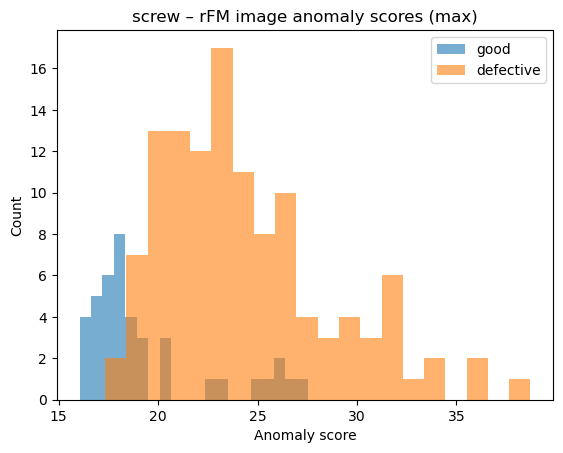

In [10]:
plt.hist(y_score_max_rfm[y_true_rfm == 0], bins=20, alpha=0.6, label="good")
plt.hist(y_score_max_rfm[y_true_rfm == 1], bins=20, alpha=0.6, label="defective")
plt.legend()
plt.title(f"{CLASS_NAME} – rFM image anomaly scores (max)")
plt.xlabel("Anomaly score")
plt.ylabel("Count")
plt.show()

## Save heatmaps & overlays rFM for ALL test images

In [11]:
save_root = Path(DATA_ROOT) / "results_rfm" / CLASS_NAME
heatmap_dir = save_root / "heatmaps"
overlay_dir = save_root / "overlays"

heatmap_dir.mkdir(parents=True, exist_ok=True)
overlay_dir.mkdir(parents=True, exist_ok=True)

print(f"Saving rFM heatmaps to: {heatmap_dir}")
print(f"Saving rFM overlays to: {overlay_dir}")

for i in range(len(test_dataset)):
    img_t, label, path = test_dataset[i]

    anomaly_map_rfm = compute_anomaly_map_rfm(
        img_t,
        feature_extractor,
        memory_bank_rfm,
        mu_rfm,
        std_rfm,
        k=10,
    )

    am_up = upsample_anomaly_map(anomaly_map_rfm, IMG_SIZE)
    am_norm = (am_up - am_up.min()) / (am_up.max() - am_up.min() + 1e-8)

    orig = Image.open(path).convert("RGB")
    orig = orig.resize((IMG_SIZE, IMG_SIZE))
    orig_np = np.array(orig)

    base = Path(path).stem + f"_label{label}"

    # heatmap
    plt.figure()
    plt.axis("off")
    plt.imshow(am_norm, cmap="jet")
    plt.tight_layout(pad=0)
    plt.savefig(heatmap_dir / f"{base}.png", bbox_inches="tight", pad_inches=0)
    plt.close()

    # overlay
    plt.figure()
    plt.axis("off")
    plt.imshow(orig_np)
    plt.imshow(am_norm, cmap="jet", alpha=0.5)
    plt.tight_layout(pad=0)
    plt.savefig(overlay_dir / f"{base}.png", bbox_inches="tight", pad_inches=0)
    plt.close()

print("Done saving rFM visualizations")


Saving rFM heatmaps to: C:\Users\snehi\Documents\Deep Learning\mvtec_anomaly_detection\results_rfm\screw\heatmaps
Saving rFM overlays to: C:\Users\snehi\Documents\Deep Learning\mvtec_anomaly_detection\results_rfm\screw\overlays
Done saving rFM visualizations


In [12]:
from pathlib import Path

def get_defect_type_from_path(path, class_name):
    """
    path: string or Path to a test image
    returns: defect type string, e.g. 'color', 'cut', 'hole', 'metal_contamination', 'thread', or 'good'
    """
    p = Path(path)
    parts = p.parts

    if "good" in parts:
        return "good"
    if "test" in parts:
        idx = parts.index("test")
        if idx + 1 < len(parts):
            return parts[idx + 1]
    return "unknown"


## load + prepare ground-truth mask

In [13]:
from PIL import Image
import numpy as np

def load_ground_truth_mask(img_path, data_root, class_name, img_size):
    """
    img_path: path of test image
    data_root: DATA_ROOT (mvtec_anomaly_detection root)
    class_name: e.g. 'carpet'
    returns: binary numpy array [img_size, img_size] with values 0 or 1
    """
    img_path = Path(img_path)
    defect_type = get_defect_type_from_path(img_path, class_name)

    if defect_type == "good":
        # normally no mask for good images
        return None

    # e.g. DATA_ROOT/class_name/ground_truth/defect_type/000_mask.png
    stem = img_path.stem          # '000'
    mask_name = stem + "_mask.png"

    mask_path = (
        Path(data_root)
        / class_name
        / "ground_truth"
        / defect_type
        / mask_name
    )

    if not mask_path.exists():
        print("No mask found for", img_path, "expected", mask_path)
        return None

    mask = Image.open(mask_path).convert("L")  # grayscale
    # resize to same size as anomaly map / your overlays
    mask = mask.resize((img_size, img_size), resample=Image.NEAREST)
    mask_np = np.array(mask)

    # MVTec masks are usually 0 (background) and 255 (defect)
    mask_bin = (mask_np > 0).astype(np.uint8)
    return mask_bin


In [14]:
# Reuse upsampling helper
import torch.nn.functional as F

def upsample_anomaly_map(anomaly_map, img_size):
    """
    anomaly_map: torch.Tensor [Hf,Wf] on CPU
    returns: numpy array [img_size, img_size]
    """
    am = anomaly_map.unsqueeze(0).unsqueeze(0)  # [1,1,Hf,Wf]
    am_up = F.interpolate(
        am,
        size=(img_size, img_size),
        mode="bilinear",
        align_corners=False,
    )
    return am_up.squeeze().cpu().numpy()


## Pixel-level ROC-AUC (rFM only)
That gives you:
- Image-level AUC (what you already have) – good vs defect classification.
- Pixel-level AUC – how well the heatmap aligns with ground-truth defect regions.

In [15]:
# m
pixel_y_true_rfm = []
pixel_scores_rfm = []

for i in range(len(test_dataset)):
    img_t, label, path = test_dataset[i]
    if label == 0:
        continue  # only defective images have masks

    anomaly_map_rfm = compute_anomaly_map_rfm(
        img_t,
        feature_extractor,
        memory_bank_rfm,
        mu_rfm,
        std_rfm,
        k=10,
    )
    am_up_rfm = upsample_anomaly_map(anomaly_map_rfm, IMG_SIZE)

    gt_mask = load_ground_truth_mask(path, DATA_ROOT, CLASS_NAME, IMG_SIZE)
    if gt_mask is None:
        continue

    pixel_y_true_rfm.append(gt_mask.flatten())
    pixel_scores_rfm.append(am_up_rfm.flatten())

if len(pixel_y_true_rfm) > 0:
    pixel_y_true_rfm = np.concatenate(pixel_y_true_rfm)
    pixel_scores_rfm = np.concatenate(pixel_scores_rfm)

    pixel_auc_rfm = roc_auc_score(pixel_y_true_rfm, pixel_scores_rfm)
    print(f"[{CLASS_NAME}] rFM – Pixel ROC AUC: {pixel_auc_rfm:.4f}")
else:
    print("No masks found for rFM pixel-level evaluation.")


[screw] rFM – Pixel ROC AUC: 0.9295


## Save GT + Heatmap + Overlay for all defective images

In [16]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Directory to save triplet visualizations
triplet_dir = Path(DATA_ROOT) / "results_rfm" / CLASS_NAME / "triplets"
triplet_dir.mkdir(parents=True, exist_ok=True)

print(f"Saving GT + heatmap + overlay triplets to: {triplet_dir}")

for i in range(len(test_dataset)):
    img_t, label, path = test_dataset[i]

    # Only defective images (label=1) have masks
    if label == 0:
        continue

    # Compute rFM anomaly map
    anomaly_map_rfm = compute_anomaly_map_rfm(
        img_t,
        feature_extractor,
        memory_bank_rfm,
        mu_rfm,
        std_rfm,
        k=10,
    )
    am_up_rfm = upsample_anomaly_map(anomaly_map_rfm, IMG_SIZE)

    # Normalize heatmap for visualization
    am_norm = (am_up_rfm - am_up_rfm.min()) / (am_up_rfm.max() - am_up_rfm.min() + 1e-8)

    # Load original image (resized)
    orig = Image.open(path).convert("RGB")
    orig = orig.resize((IMG_SIZE, IMG_SIZE))
    orig_np = np.array(orig)

    # Load GT mask
    gt_mask = load_ground_truth_mask(path, DATA_ROOT, CLASS_NAME, IMG_SIZE)
    if gt_mask is None:
        print("No mask for:", path)
        continue

    # Make a 3-panel figure: Original | GT | Overlay
    plt.figure(figsize=(10, 4))

    # Original
    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.axis("off")
    plt.imshow(orig_np)

    # Ground-truth mask
    plt.subplot(1, 3, 2)
    plt.title("GT mask")
    plt.axis("off")
    plt.imshow(gt_mask, cmap="gray")

    # Overlay
    plt.subplot(1, 3, 3)
    plt.title("rFM overlay")
    plt.axis("off")
    plt.imshow(orig_np)
    plt.imshow(am_norm, cmap="jet", alpha=0.5)

    plt.tight_layout()

    # Save figure
    base = Path(path).stem
    out_path = triplet_dir / f"{base}_triplet.png"
    plt.savefig(out_path, bbox_inches="tight", pad_inches=0)
    plt.close()

print("Done saving triplets for all defective images.")


Saving GT + heatmap + overlay triplets to: C:\Users\snehi\Documents\Deep Learning\mvtec_anomaly_detection\results_rfm\screw\triplets
Done saving triplets for all defective images.


## Global pixel-level ROC curve (once)

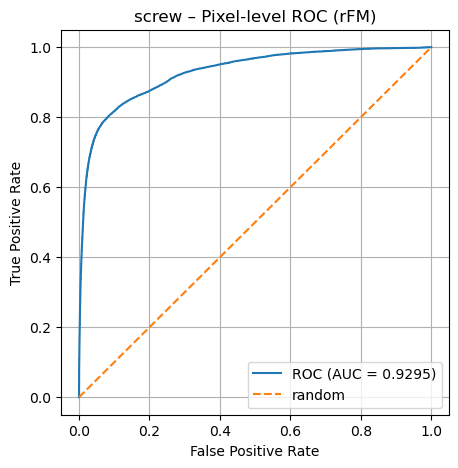

In [17]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(pixel_y_true_rfm, pixel_scores_rfm)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"{CLASS_NAME} – Pixel-level ROC (rFM)")
plt.legend()
plt.grid(True)

roc_dir = Path("results_rfm") / CLASS_NAME
roc_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(roc_dir / "pixel_roc_rfm.png", bbox_inches="tight", pad_inches=0)
plt.show()
